In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from combat.pycombat import pycombat

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from pymrmre import mrmr
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore', module='pymrmre')
warnings.simplefilter(action='ignore', category=FutureWarning)

### Metabolites dataset:

File **data_zscore_comp_id.csv** contains z-score values of metabolites for each patient.

Function for loading and preprocessing data includes handling NaN values and outliers, batch effect correction and selection of subset for further analysys.


In [2]:
def data_load_preprocess():
    
    # load and drop all-NaN rows
    met_df = (pd.read_csv("./metabolomics/data_zscore_comp_id.csv"))
    met_df.set_index('Unnamed: 0', inplace=True)
    met_df.index.name = None
    met_df.dropna(axis=0, how='all', inplace=True)
    
    # drop rows containing >80% NaN
    perc = 0.8
    min_count =  int((1 - perc)*met_df.shape[1] + 1)
    met_df.dropna(axis=0, thresh=min_count, inplace=True)
    
    # fill rest of NaN values     
    met_df.fillna(0, inplace=True)
    met_df = met_df.T
    
    # batch effect correction
    clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
    met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T
    
    # drop outliers
    outliers = [17, 163, 222, 225, 255, 293, 362]
    met_df_corrected.drop(met_df_corrected.iloc[outliers].index, axis=0, inplace=True)
    
    # select patients who do not take aspirin     
    target = clin_df[['pe', 'ASA']]
    target.index = met_df.index
    df = met_df_corrected.join(target)
    df = df[df['ASA'] == False].copy(deep=True)
    df.drop(['ASA'], axis = 1, inplace=True)
    target = df['pe']
    df.drop(['pe'], axis=1, inplace=True)
    
    return df, target

In [3]:
class MRMR(BaseEstimator):
    def __init__(self, solution_length=1):
        self.solution_length = solution_length
        self.solution = []
        
    def fit(self, X_train, y_train):
        self.solution = mrmr.mrmr_ensemble(features=X_train, 
                                           targets=pd.DataFrame(y_train), 
                                           solution_length=self.solution_length, 
                                           solution_count=1).iloc[0][0]
        return self
        
    def transform(self, X_train):
        return X_train[self.solution]

In [4]:
class KBest(BaseEstimator):
    def __init__(self, score_func = f_classif, k=100):
        self.score_func = score_func
        self.k = k
        
    def fit(self, X_train, y_train):
        self.selector = SelectKBest(score_func=self.score_func, k=self.k)
        self.selector.fit(X_train, y_train)
        return self

        
    def transform(self, X_train):
        features = self.selector.get_support(indices=True)
        new_features = X_train.columns[features]
        
        return X_train[new_features]
        

In [5]:
def get_best_params(pipeline, params, X, y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, 
                             scoring=['f1', 'roc_auc'], refit='f1')

    scores = cross_validate(grid, X, y, scoring=['accuracy', 'f1', 'roc_auc'],
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=47))
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

In [6]:
X, y = data_load_preprocess()

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


### Finding best parameters (using grid search) for model with SelectKBest feature selector
This step is taking around 80 minutes, so best parameters are saved as dict for quick execution.

#### Scores obtained:

{'fit_time': array([1006.92296648, 1007.44742203, 1012.41200638, 1008.40179944,
        1006.52522278]),
        
 'score_time': array([0.01507545, 0.01467943, 0.01476455, 0.01439404, 0.01589751]),
 
 'test_accuracy': array([0.75409836, 0.62295082, 0.75409836, 0.60655738, 0.73770492]),
 
 'test_f1': array([0.51612903, 0.37837838, 0.51612903, 0.36842105, 0.57894737]),
 
 'test_roc_auc': array([0.8283208 , 0.67669173, 0.8358396 , 0.7       , 0.75731707])}


In [7]:
params_kbest = {
    'kbest__score_func' : [f_classif, mutual_info_classif] ,
    'kbest__k' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}

model_kbest = Pipeline([('kbest', KBest()), ('scaler', StandardScaler()), ('classifier', XGBClassifier())])

# uncomment for executing grid search for best parameters:
# scores_kbest, best_params_kbest = get_best_params(model_kbest, params_kbest, X, y)

# best_params_kbest = {
#     'classifier__max_depth': 10,
#     'classifier__n_estimators': 100,
#     'kbest__k' : 140,
#     'kbest__score_func' : f_classif
# }


best_params_kbest = {
    'classifier__max_depth': 10,
    'classifier__n_estimators': 200,
    'kbest__k': 40,
    'kbest__score_func': f_classif
}

model_kbest.set_params(**best_params_kbest)
model_kbest.fit(X, y)

Pipeline(steps=[('kbest', KBest(k=40)), ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

### Finding best parameters (using grid search) for model with MRMR feature selector
This step is taking around 25 minutes, so best parameters are saved as dict for quick execution.

#### Scores obtained:
{'fit_time': array([307.36636376, 306.25228882, 325.61197495, 313.65118551, 306.5383637 ]),

 'score_time': array([0.01570821, 0.01510549, 0.01685596, 0.0157218 , 0.01474524]),
 
 'test_accuracy': array([0.81967213, 0.78688525, 0.78688525, 0.6557377 , 0.6557377 ]),
 
 'test_f1': array([0.66666667, 0.64864865, 0.58064516, 0.4       , 0.46153846]),
 
 'test_roc_auc': array([0.84837093, 0.88095238, 0.84837093, 0.76463415, 0.6902439 ])}


In [8]:
params_mrmr = {
    'mrmr__solution_length' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}

model_mrmr = Pipeline([('mrmr', MRMR()), ('scaler', StandardScaler()), ('classifier', XGBClassifier())])

# uncomment for executing grid search for best parameters:
# scores_mrmr, best_params_mrmr = get_best_params(model_mrmr, params_mrmr, X, y)

# best_params_mrmr = {
#     'classifier__max_depth': 10,
#     'classifier__n_estimators': 100,
#     'mrmr__solution_length': 120
# }

best_params_mrmr = {
    'classifier__max_depth': 10,
    'classifier__n_estimators': 100,
    'mrmr__solution_length': 40
}

model_mrmr.set_params(**best_params_mrmr)
model_mrmr.fit(X, y)

Pipeline(steps=[('mrmr', MRMR(solution_length=40)),
                ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [9]:
def top_k_importances(model, k):
    importances = sorted(zip(X.columns, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)
    values = [x[1] for x in importances[:k]]
    labels = [x[0] for x in importances[:k]]

    plt.bar(range(k), values)
    plt.xticks(range(k), labels=labels)
    plt.show()
    
    comp_df = pd.read_csv('./metabolomics/compAnno.csv')
    return comp_df[comp_df.COMP_ID.isin(labels)]

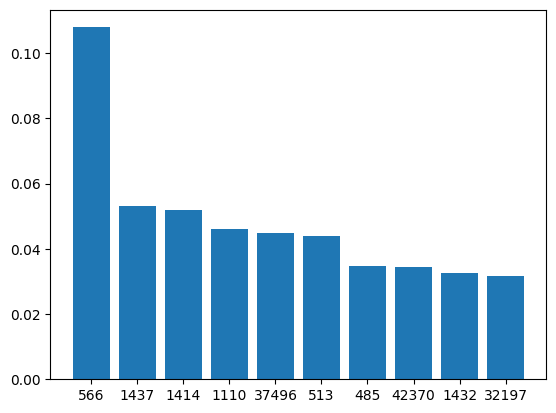

,BIOCHEMICAL,PATHWAY_SORTORDER,SUPER_PATHWAY,SUB_PATHWAY,COMP_ID,PLATFORM,CHEMICAL_ID,PUBCHEM,CAS,KEGG,HMDB_ID
0,S-1-pyrroline-5-carboxylate,64.0,Amino Acid,Glutamate Metabolism,42370,Pos Early,35,11966181,2906-39-0,C04322,HMDB0001301
1,spermidine,553.0,Amino Acid,Polyamine Metabolism,485,Pos Early,50,1102,124-20-9,C00315,HMDB0001257
9,3-phosphoglycerate,1254.0,Carbohydrate,"Glycolysis, Gluconeogenesis, and Pyruvate Meta...",1414,Pos Early,132,724,80731-10-8,C00597,HMDB0000807
18,N-acetylputrescine,546.0,Amino Acid,Polyamine Metabolism,37496,Pos Early,192,122356,18233-70-0,C02714,HMDB0002064
25,arachidonate (20:4n6),1591.0,Lipid,Long Chain Polyunsaturated Fatty Acid (n3 and n6),1110,Neg,229,444899,506-32-1,C00219,HMDB0001043
28,2-hydroxyphenylacetate,161.0,Amino Acid,Phenylalanine Metabolism,1432,Polar,235,11970,614-75-5,C05852,HMDB0000669
29,3-(4-hydroxyphenyl)lactate,186.0,Amino Acid,Tyrosine Metabolism,32197,Neg,240,9378,6482-98-0,C03672,HMDB0000755
30,phenylpyruvate,155.0,Amino Acid,Phenylalanine Metabolism,566,Neg,241,997,156-06-9,C00166,HMDB0000205
33,succinate,1466.0,Energy,TCA Cycle,1437,Polar,252,1110,110-15-6,C00042,HMDB0000254
38,creatinine,537.0,Amino Acid,Creatine Metabolism,513,Pos Early,275,588,60-27-5,C00791,HMDB0000562


In [10]:
top_k_importances(model_kbest, 10)

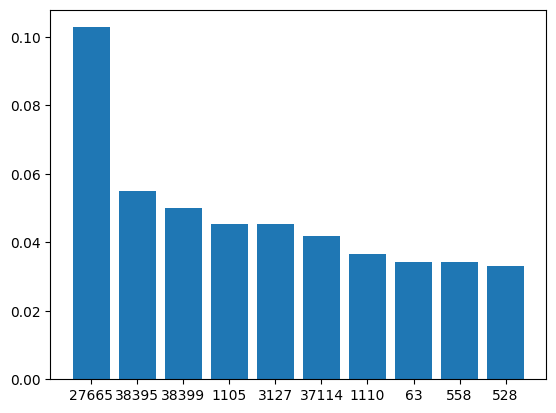

,BIOCHEMICAL,PATHWAY_SORTORDER,SUPER_PATHWAY,SUB_PATHWAY,COMP_ID,PLATFORM,CHEMICAL_ID,PUBCHEM,CAS,KEGG,HMDB_ID
2,1-methylnicotinamide,4336.0,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,27665,Pos Early,55,457,1005-24-9,C02918,HMDB0000699
3,"12,13-DiHOME",2048.0,Lipid,"Fatty Acid, Dihydroxy",38395,Neg,62,10236635,263399-35-5,C14829,HMDB0004705
5,alpha-ketoglutarate,1463.0,Energy,TCA Cycle,528,Polar,93,51,"328-50-7,22202-68-2,305-72-6",C00026,HMDB0000208
12,hypoxanthine,4140.0,Nucleotide,"Purine Metabolism, (Hypo)Xanthine/Inosine cont...",3127,Neg,171,"790,135398638",68-94-0,C00262,HMDB0000157
13,"9,10-DiHOME",2049.0,Lipid,"Fatty Acid, Dihydroxy",38399,Neg,179,9966640,263399-34-4,C14828,HMDB0004704
14,linoleate (18:2n6),1585.0,Lipid,Long Chain Polyunsaturated Fatty Acid (n3 and n6),1105,Neg,180,5280450,60-33-3,C01595,"HMDB0006270,HMDB0000673"
23,N6-methyladenosine,4174.0,Nucleotide,"Purine Metabolism, Adenine containing",37114,Neg,213,102175,1867-73-8,NaN,HMDB0004044
24,adenosine 5'-diphosphoribose (ADP-ribose),4346.0,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,558,Neg,215,192,68414-18-6,C00301,HMDB0001178
25,arachidonate (20:4n6),1591.0,Lipid,Long Chain Polyunsaturated Fatty Acid (n3 and n6),1110,Neg,229,444899,506-32-1,C00219,HMDB0001043
35,cholesterol,3212.0,Lipid,Sterol,63,Pos Late,266,"5997,6432564,11025495",57-88-5,C00187,HMDB0000067


In [11]:
top_k_importances(model_mrmr, 10)

### Patients dataset:

File **sampleAttr.csv** containst information on patients form 4 clinical studies. 

Loading dataset, fixing format and adding BMI column:

In [12]:
clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
clin_df['age'] = [float(x.replace(',', '.')) for x in clin_df['age']]
clin_df['weight'] = [float(x.replace(',', '.')) for x in clin_df['weight']]
clin_df['height'] = [float(x.replace(',', '.')) for x in clin_df['height']]
clin_df['smoking'] = [1 if x == 'Smoker' or x == '1' else 0 for x in clin_df.smoking]
clin_df['BMI'] = clin_df['weight'] / (clin_df['height'] / 100)**2

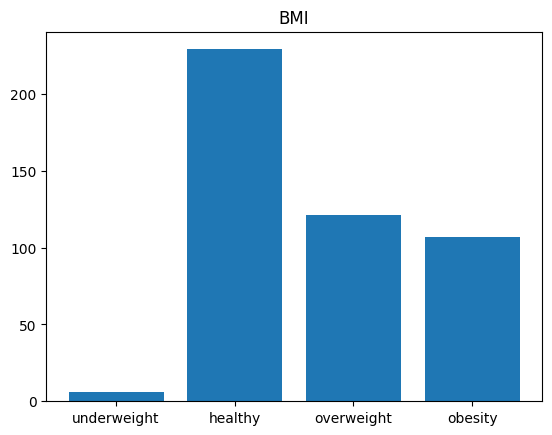

In [13]:
bmi = [clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] < 25.0].shape[0] - clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] >= 25].shape[0] - clin_df[clin_df['BMI'] >= 30].shape[0],
 clin_df[clin_df['BMI'] >= 30].shape[0]]

plt.bar(range(4), bmi)
plt.xticks(range(4), ['underweight', 'healthy', 'overweight', 'obesity'])
plt.title('BMI')
plt.show()

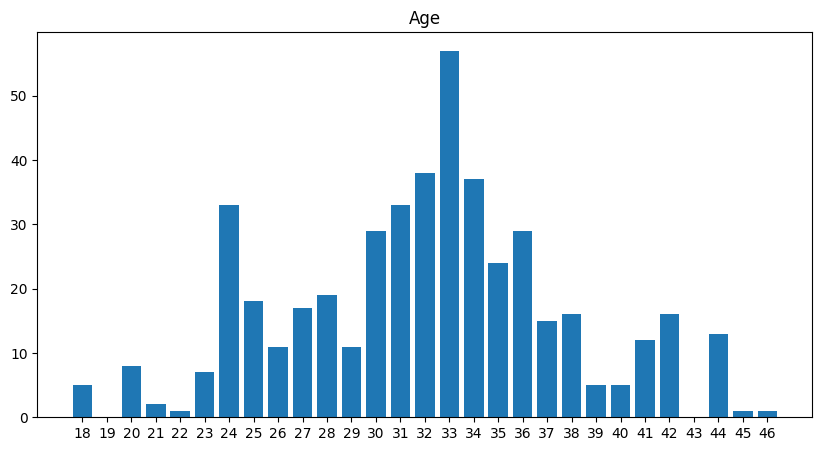

In [14]:
age = np.rint(clin_df.age).sort_values()

plt.figure(figsize=(10, 5))
plt.bar(range(18, 47), np.bincount(age)[18:])
plt.xticks(range(18, 47))
plt.title('Age')
plt.show()

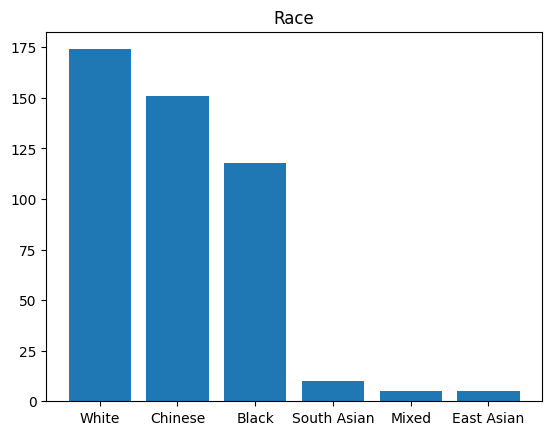

In [15]:
race = clin_df.race.value_counts()

plt.bar(range(race.shape[0]), race)
plt.xticks(range(race.shape[0]), labels=race.index)
plt.title('Race')
plt.show()

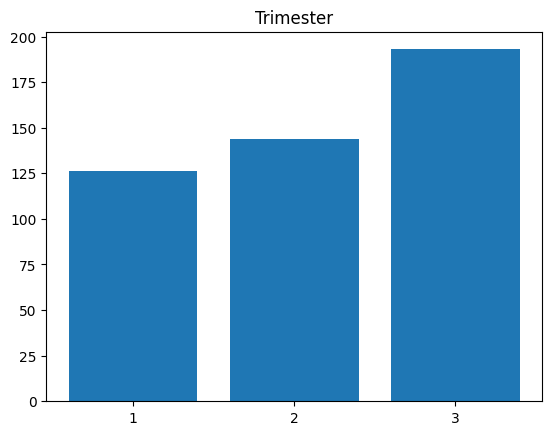

In [16]:
trimester = clin_df.trimester.value_counts().sort_index()
plt.bar(range(trimester.shape[0]), trimester)
plt.xticks(range(trimester.shape[0]), labels=trimester.index)
plt.title('Trimester')
plt.show()

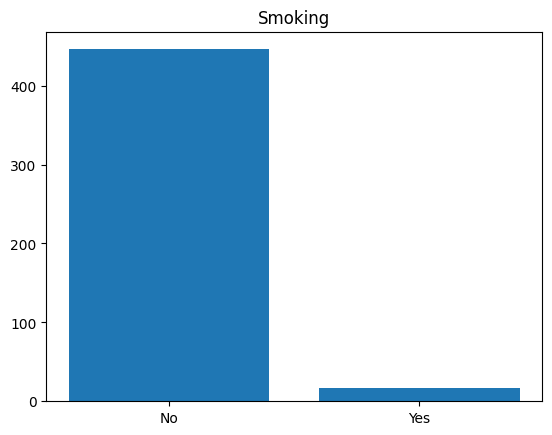

In [17]:
plt.bar([0, 1], np.bincount(clin_df.smoking))
plt.xticks([0, 1], ['No', 'Yes'])
plt.title('Smoking')
plt.show()

In [18]:
from scipy import stats

In [19]:
# get feature importances from xgb
def feature_importances(model):
    return sorted(zip(X.columns, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)

# apply statistics test, groups divided by preeclampsy indicator -> returns statisticaly important features
def statistics_test(test_type):
    stat_important_features = []
    test_df = clin_df[['trimester', 'sIDs', 'pe']].join(X, on='sIDs', how='right')
    group1 = test_df[test_df.pe == 1]
    group2 = test_df[test_df.pe == 0]
    
    for metabolite in X.columns:
        t_stat, p_value = test_type(group1[metabolite], group2[metabolite])
        if p_value < 0.05:
            stat_important_features.append(metabolite)

    return stat_important_features

# intersection for both sets of impotrant features with xgb rank and importance value
def find_important_features(model, test_type):
    model_importances = feature_importances(model)
    stat_importances = statistics_test(test_type)
    
    importance_dict = {}
    v = [x[0] for x in model_importances]
    for m in stat_importances:
        if m in v:
            importance_dict[m] = (v.index(m), model_importances[v.index(m)][1])
        
    return importance_dict

In [20]:
importances_kbest = find_important_features(model_kbest, stats.mannwhitneyu)
importances_mrmr = find_important_features(model_mrmr, stats.mannwhitneyu)

In [21]:
importances_kbest

{437: (14, 0.027832966),
 1417: (24, 0.017734773),
 1105: (37, 0.008895722),
 2829: (34, 0.010952223),
 42382: (35, 0.010337764),
 32197: (9, 0.03182749),
 1769: (32, 0.011152559)}

In [22]:
importances_mrmr

{437: (14, 0.024179896),
 1417: (15, 0.023961257),
 1105: (3, 0.04528157),
 2829: (10, 0.030560445),
 42382: (28, 0.014173864),
 32197: (38, 0.0056336126),
 1769: (31, 0.012441269)}

In [23]:
# important metabolites information
comp_df = pd.read_csv('./metabolomics/compAnno.csv')
comp_df[comp_df.COMP_ID.isin(importances_mrmr.keys())]

,BIOCHEMICAL,PATHWAY_SORTORDER,SUPER_PATHWAY,SUB_PATHWAY,COMP_ID,PLATFORM,CHEMICAL_ID,PUBCHEM,CAS,KEGG,HMDB_ID
4,5-hydroxyindoleacetate,295.0,Amino Acid,Tryptophan Metabolism,437,Neg,71,1826,54-16-0,C05635,HMDB0000763
6,kynurenate,277.0,Amino Acid,Tryptophan Metabolism,1417,Neg,98,3845,492-27-3,C01717,HMDB0000715
14,linoleate (18:2n6),1585.0,Lipid,Long Chain Polyunsaturated Fatty Acid (n3 and n6),1105,Neg,180,5280450,60-33-3,C01595,"HMDB0006270,HMDB0000673"
19,N-formylmethionine,443.0,Amino Acid,"Methionine, Cysteine, SAM and Taurine Metabolism",2829,Neg,194,439750,4289-98-9,C03145,HMDB0001015
20,S-adenosylhomocysteine (SAH),452.0,Amino Acid,"Methionine, Cysteine, SAM and Taurine Metabolism",42382,Neg,197,439155,979-92-0,C00021,HMDB0000939
29,3-(4-hydroxyphenyl)lactate,186.0,Amino Acid,Tyrosine Metabolism,32197,Neg,240,9378,6482-98-0,C03672,HMDB0000755
37,cortisone,3335.0,Lipid,Corticosteroids,1769,Neg,273,222786,53-06-5,C00762,HMDB0002802


In [24]:
test = clin_df[['trimester', 'sIDs', 'pe']].join(X[importances_mrmr.keys()], on='sIDs', how='right')
group0 = test[test.pe == 0].drop('pe', axis = 1).groupby('trimester')
group1 = test[test.pe == 1].drop('pe', axis = 1).groupby('trimester')

In [25]:
group0.agg(['mean', 'median', 'std'])

437                           1417                       \
               mean    median       std      mean    median       std   
trimester                                                               
1         -0.101212 -0.142612  0.438641  0.269761  0.200547  0.952392   
2         -0.063013 -0.011331  0.281794 -0.260370 -0.293799  0.716045   
3         -0.102930 -0.222366  0.497855 -0.302375 -0.422952  0.760702   

              1105                          2829   ...               42382  \
               mean    median       std      mean  ...       std      mean   
trimester                                          ...                       
1         -0.119068 -0.255648  0.751813 -0.047024  ...  0.872326  0.000690   
2         -0.131213 -0.164673  0.588994 -0.047866  ...  0.808792 -0.023741   
3         -0.136605 -0.223414  0.772688 -0.090451  ...  0.813653  0.094378   

                                  32197                         1769   \
             median       std      mean    median       std      mean   
trimester                                                               
1         -0.080479  0.507548  0.124988  0.149964  0.938051 -0.108232   
2         -0.009726  0.715417 -0.222289 -0.295763  0.780834  0.206447   
3          0.093848  0.689825 -0.247951 -0.319025  0.619427  0.380863   

                               
             median       std  
trimester                      
1         -0.151124  0.499618  
2          0.159592  0.581871  
3          0.443684  0.572690  

[3 rows x 21 columns]

In [26]:
group1.agg(['mean', 'median', 'std'])

437                          1417                       \
               mean    median      std      mean    median       std   
trimester                                                              
1         -0.011331 -0.011331  0.00000  0.073701  0.279504  0.393076   
2         -0.011331 -0.011331  0.00000 -0.084719 -0.047300  0.498258   
3          0.050595 -0.107136  0.77443  0.218520  0.204872  0.859138   

              1105                          2829   ...               42382  \
               mean    median       std      mean  ...       std      mean   
trimester                                          ...                       
1         -0.050662 -0.236145  0.744538 -0.178150  ...  0.434793  0.021188   
2         -0.066254  0.025337  0.658265  0.090938  ...  0.474991  0.229106   
3          0.108866 -0.040499  0.738777  0.224933  ...  0.733800  0.212510   

                                  32197                         1769   \
             median       std      mean    median       std      mean   
trimester                                                               
1          0.162475  0.783107  0.010791 -0.023838  0.531756  0.392667   
2          0.191931  0.879505 -0.159591 -0.062274  0.574586  0.402860   
3          0.186219  0.747005  0.194003  0.188569  0.781676  0.549183   

                               
             median       std  
trimester                      
1          0.571275  0.917684  
2          0.468222  0.900877  
3          0.399884  0.649591  

[3 rows x 21 columns]

In [27]:
mean_values0 = group0.agg('mean')
mean_values1 = group1.agg('mean')

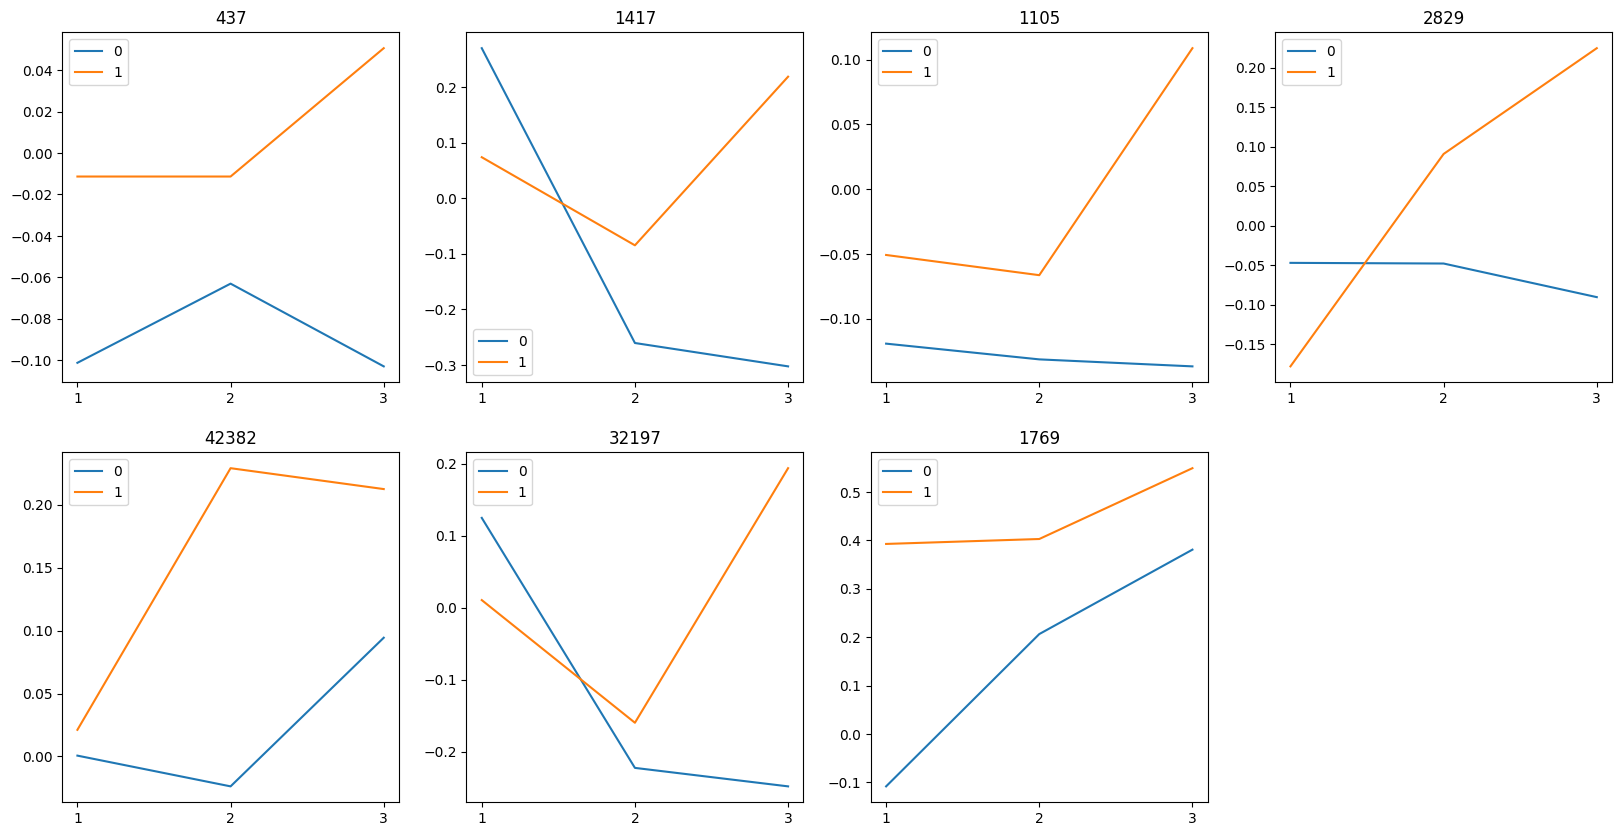

In [28]:
i = 1
plt.figure(figsize=(20, 10))
for m in importances_mrmr.keys():
    plt.subplot(2, 4, i)
    plt.plot(mean_values0.index, mean_values0[m])
    plt.plot(mean_values1.index, mean_values1[m])
    
    plt.xticks(mean_values0.index)
    plt.title(m)
    plt.legend(['0', '1'])
    
    i += 1
    
    
plt.show()

In [29]:
# T test -> Assumptions of normal distribution
# Shapiro test -> test for normal distribution in data (0-hypothesis: data is not from normal distribution)

In [30]:
def check_normal_distribution():
    normal = []
    for metabolite in X.columns:
        s, p = stats.shapiro(X[metabolite])
        if p > 0.05:
            normal.append(metabolite)
            
    return normal

In [31]:
normal_distr_features = check_normal_distribution()

In [32]:
test_df = clin_df[['trimester', 'sIDs', 'pe']].join(X[normal_distr_features], on='sIDs', how='right')
group1 = test_df[test_df.pe == 1]
group2 = test_df[test_df.pe == 0]

t_test_res = []
for m in normal_distr_features:
    t, p = stats.ttest_ind(group1[m], group2[m])
    if p < 0.05:
        t_test_res.append(m)

In [33]:
t_test_res

[1769, 54, 15506, 52461, 42459, 52500]

In [34]:
proba = feature_importances(model_kbest)
proba = [x[0] for x in proba]
for m in t_test_res:
    if m in proba:
        print(m)

1769


In [35]:
comp_df[comp_df.COMP_ID == 1769]

,BIOCHEMICAL,PATHWAY_SORTORDER,SUPER_PATHWAY,SUB_PATHWAY,COMP_ID,PLATFORM,CHEMICAL_ID,PUBCHEM,CAS,KEGG,HMDB_ID
37,cortisone,3335.0,Lipid,Corticosteroids,1769,Neg,273,222786,53-06-5,C00762,HMDB0002802


In [ ]:
def plt_bmi_corr(met_id):
    test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[met_id], on='sIDs', how='right')
    plt.scatter(test.BMI[test.pe == 0], test[met_id][test.pe == 0])
    plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1])

    plt.legend([0, 1])
    plt.show()

In [ ]:
plt_bmi_corr(1105)

In [ ]:
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X, on='sIDs', how='right')


In [ ]:
bmi_met_corr = test.corr()['BMI'][3:]

In [ ]:
bmi_met_corr.max()

In [ ]:
bmi_met_corr.min()

In [ ]:
test1 = test[test.trimester == 1]

In [ ]:
bmi_met_corr1 = test1.corr()['BMI'][3:]

In [ ]:
bmi_met_corr1.max()

In [ ]:
bmi_met_corr1.argmax()

In [ ]:
bmi_met_corr1.index[156]

In [ ]:
# comp_df = pd.read_csv('./metabolomics/compAnno.csv')

In [ ]:
# comp_df[comp_df.COMP_ID == 18368]

In [ ]:
bmi_met_corr1.min()